## What is TensorFlow?
<div style="text-align:justify"><a href="https://www.tensorflow.org/">TensorFlow</a> is an open source software library for numerical computation using data flow graphs. Nodes in the graph represent mathematical operations, while the graph edges represent the multidimensional data arrays (tensors) communicated between them. The flexible architecture allows you to deploy computation to one or more CPUs or GPUs in a desktop, server, or mobile device with a single API. TensorFlow was originally developed by researchers and engineers working on the Google Brain Team within Google's Machine Intelligence research organization for the purposes of conducting machine learning and deep neural networks research, but the system is general enough to be applicable in a wide variety of other domains as well.It is currently used for both research and production by 50 different teams in dozens of commercial Google products, such as speech recognition, Gmail, Google Photos, and search, many of which had previously used its predecessor DistBelief.</div>

## What is fastText?
<a href ="https://pypi.python.org/pypi/fasttext">fastText</a> is a library for efficient learning of word representations and sentence classification. fastText created by Facebook

---

## Installation

In [ ]:
!sudo pip3 install --user Cython
!sudo pip3 install --user fasttext
#!sudo pip install tensorflow

# Cython is needed to install fasttext


# to install tensorflow use this link
# https://www.tensorflow.org/versions/r0.10/get_started/os_setup.html#pip-installation

## Importing

In [1]:
import tensorflow as tf
import fasttext as ft
import numpy as np
import matplotlib.pyplot as plt
import urllib
import pandas
import os
import tarfile

from os import path
from time import time
from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.platform import gfile
#from __future__ import absolute_import
#from __future__ import division
#from __future__ import print_function
from sklearn import metrics
from tensorflow.contrib import learn

%matplotlib inline

## Testing
Lets test, if both TensorFlow and FastText installed properly.

In [2]:
%%file test.txt
Mount Everest, also known in Nepal as Sagarmāthā and in China as Chomolungma, is Earth's highest mountain. Its peak is 8,848 metres (29,029 ft) above sea level. Mount Everest is located in the Mahalangur mountain range in Nepal. The international border between China (Tibet Autonomous Region) and Nepal runs across Everest's precise summit point. Its massif includes neighbouring peaks Lhotse, 8,516 m (27,940 ft); Nuptse, 7,855 m (25,771 ft) and Changtse, 7,580 m (24,870 ft).
In 1856, the Great Trigonometrical Survey of India established the first published height of Everest, then known as Peak XV, at 8,840 m (29,002 ft). The current official height of 8,848 m (29,029 ft) as recognised by China and Nepal was established by a 1955 Indian survey and subsequently confirmed by a Chinese survey in 1975. In 2005, China remeasured the height of the mountain and got a result of 8844.43 m. An argument regarding the height between China and Nepal lasted 5 years from 2005 to 2010. China argued it should be measured by its rock height which is 8844 m but Nepal said it should be measured by its snow height 8848 m. In 2010, an agreement was finally reached by both sides that the height of Everest is 8,848 m and Nepal recognises China's claim that the rock height of Everest is 8,844 m.

Writing test.txt


A <a href="https://www.tensorflow.org/api_docs/python/client/session_management#Session">Session</a> object encapsulates the environment in which Operation objects are executed, and Tensor objects are evaluated.

In [3]:
%%time
# Build a graph
hello = tf.constant('Hello, ')
world = tf.constant('TensorFlow!')
hw = hello + world
# Launch the graph in a sessions.
sess = tf.Session()
# Evaluate the tensor 'hello'
print(sess.run(hw))

b'Hello, TensorFlow!'
CPU times: user 539 ms, sys: 286 ms, total: 825 ms
Wall time: 1.73 s


In [4]:
# Learn word vectors using cbow model from fastText
model = ft.cbow('test.txt', 'model')

In [5]:
# Print list of words in dictionary
print(model.words)

{'the', 'of', 'm', 'China', 'is', 'Nepal', 'in', 'height', 'and', 'by'}


# 1. TensorFlow

### 1.1. Download and prepare the dataset
<div style="text-align:justify">
DBpedia is a crowd-sourced community effort to extract structured information from Wikipedia and make this information available on the Web. <br><br>
Here we use DBpedia ontology dataset.<br>
&emsp;The DBpedia ontology classification dataset is constructed by picking 14 non-overlapping classes from DBpedia 2014. They are listed in classes.txt. From each of thse 14 ontology classes, we randomly choose 40,000 training samples and 5,000 testing samples. Therefore, the total size of the training dataset is 560,000 and testing dataset 70,000.<br>

&emsp;The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 3 columns in them, corresponding to class index (1 to 14), title and content. The title and content are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). There are no new lines in title or content.</div>

In [6]:
DBPEDIA_URL = 'https://www.dropbox.com/s/8n9unxr3p6d13lr/dbpedia_csv.tar.gz?dl=1'

def maybe_download_dbpedia(data_dir):
    """Download if DBpedia data is not present."""
    train_path = os.path.join(data_dir, 'dbpedia_csv/train.csv')
    test_path = os.path.join(data_dir, 'dbpedia_csv/test.csv')
    if not (gfile.Exists(train_path) and gfile.Exists(test_path)):
        archive_path = base.maybe_download(
            'dbpedia_csv.tar.gz', data_dir, DBPEDIA_URL)
        tfile = tarfile.open(archive_path, 'r:*')
        tfile.extractall(data_dir)

def load_dbpedia(size='small', test_with_fake_data=False):
    """Get DBpedia datasets from CSV files."""
    if not test_with_fake_data:
        data_dir = os.path.join(os.getenv('TF_EXP_BASE_DIR', ''), 'dbpedia_data')
        maybe_download_dbpedia(data_dir)

        train_path = os.path.join(data_dir, 'dbpedia_csv', 'train.csv')
        test_path = os.path.join(data_dir, 'dbpedia_csv', 'test.csv')

        if size == 'small':
            # Reduce the size of original data by a factor of 100.
            base.shrink_csv(train_path, 100)
            base.shrink_csv(test_path, 100)
            train_path = train_path.replace('train.csv', 'train_small.csv')
            test_path = test_path.replace('test.csv', 'test_small.csv')
    else:
        module_path = os.path.dirname(__file__)
        train_path = os.path.join(module_path, 'data', 'text_train.csv')
        test_path = os.path.join(module_path, 'data', 'text_test.csv')

        # Load csv without the 1st row
    train = base.load_csv_without_header(
        train_path, target_dtype=np.int32, features_dtype=np.str, target_column=0)
    test = base.load_csv_without_header(
        test_path, target_dtype=np.int32, features_dtype=np.str, target_column=0)

    return base.Datasets(train=train, validation=None, test=test)

# Placeholder for scores and timings of evaluations
scores_timings = [[0,0],[0,0]]

### 1.2. Train and test the model

<div style="text-align:justify">In this example used the **convolution2d** layer. **convolution2d** creates a variable called **weights**, representing the convolutional kernel, that is convolved with the **inputs** to produce a **Tensor** of activations. If a **normalizer_fn** is provided (such as **batch_norm**), it is then applied. Otherwise, if **normalizer_fn** is None and a **biases_initializer** is provided then a **biases** variable would be created and added the activations. Finally, if **activation_fn** is not **None**, it is applied to the activations as well.
And logistic regression model. Docs for tf.contrib.learn can be found <a href="https://www.tensorflow.org/tutorials/tflearn/"> here</a>.</div>

In [7]:
MAX_DOCUMENT_LENGTH = 100
EMBEDDING_SIZE = 20
N_FILTERS = 10
WINDOW_SIZE = 20
FILTER_SHAPE1 = [WINDOW_SIZE, EMBEDDING_SIZE]
FILTER_SHAPE2 = [WINDOW_SIZE, N_FILTERS]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
n_words = 0


def cnn_model(x, y):
    """2 layer Convolutional network to predict from sequence of words
  to a class."""
    # Convert indexes of words into embeddings.
    # This creates embeddings matrix of [n_words, EMBEDDING_SIZE] and then
    # maps word indexes of the sequence into [batch_size, sequence_length,
    # EMBEDDING_SIZE].
    y = tf.one_hot(y, 15, 1, 0)
    word_vectors = learn.ops.categorical_variable(x, n_classes=n_words,
                                                  embedding_size=EMBEDDING_SIZE, name='words')
    word_vectors = tf.expand_dims(word_vectors, 3)
    with tf.variable_scope('CNN_Layer1'):
        # Apply Convolution filtering on input sequence.
        conv1 = tf.contrib.layers.convolution2d(word_vectors, N_FILTERS,
                                                FILTER_SHAPE1, padding='VALID')
        # Add a RELU for non linearity.
        conv1 = tf.nn.relu(conv1)
        # Max pooling across output of Convolution+Relu.
        pool1 = tf.nn.max_pool(conv1, ksize=[1, POOLING_WINDOW, 1, 1],
                               strides=[1, POOLING_STRIDE, 1, 1], padding='SAME')
        # Transpose matrix so that n_filters from convolution becomes width.
        pool1 = tf.transpose(pool1, [0, 1, 3, 2])
    with tf.variable_scope('CNN_Layer2'):
        # Second level of convolution filtering.
        conv2 = tf.contrib.layers.convolution2d(pool1, N_FILTERS,
                                                FILTER_SHAPE2, padding='VALID')
        # Max across each filter to get useful features for classification.
        pool2 = tf.squeeze(tf.reduce_max(conv2, 1), squeeze_dims=[1])

    # Apply regular WX + B and classification.
    prediction, loss = learn.models.logistic_regression(pool2, y)

    # Training optimizer
    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.contrib.framework.get_global_step(),
        optimizer='Adam', learning_rate=0.01)

    return {'class': tf.argmax(prediction, 1), 'prob': prediction}, loss, train_op


def main(unused_argv):
    global n_words
    # Prepare training and testing data
    dbpedia = load_dbpedia()
    t0 = time()
    x_train = pandas.DataFrame(dbpedia.train.data)[1]
    y_train = pandas.Series(dbpedia.train.target)
    x_test = pandas.DataFrame(dbpedia.test.data)[1]
    y_test = pandas.Series(dbpedia.test.target)

    # Process vocabulary
    vocab_processor = learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH) # Map documents to sequence of word IDs
    x_train = np.array(list(vocab_processor.fit_transform(x_train)))
    x_test = np.array(list(vocab_processor.transform(x_test)))
    n_words = len(vocab_processor.vocabulary_)
    print('Total words: %d' % n_words)

    # Build model
    classifier = learn.Estimator(model_fn=cnn_model)

    # Train and predict
    classifier.fit(x_train, y_train, steps=100)
    y_predicted = [
        p['class'] for p in classifier.predict(x_test, as_iterable=True)]
    score = metrics.accuracy_score(y_test, y_predicted)
    print('Accuracy: {0:f}'.format(score))
    
    t1 = time() - t0
    scores_timings[0][0] = score
    scores_timings[0][1] = t1
    print("Model trained and tested in %s seconds" % round(t1, 3))


tf.app.run()

Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded dbpedia_csv.tar.gz 68341698 bytes.
Instructions for updating:
Use tf.data instead.
Instructions for updating:
Use tf.data instead.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Total words: 38228
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1961355a20>, '_master': '', '_num_ps_replicas': 0, '_num_worker_

Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Consider using a class from tf.estimator.
Instructions for updating:
Use `tf.losses.softmax_cross_entropy` and explicit logits computation.
Instructions for updating:
Please switch to tf.train.get_global_step
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpcgdzjhbf/model.ckpt.
INFO:tensorflow:loss = 2.7714446, step = 0
INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpcgdzjhbf/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0050413855.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Argumen

SystemExit: 

/home/dmitriy/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 2. fastText

Before starting use fastText you need to prepare dataset or you can download it below. You need to convert the dataset to lowercase and add **label** or another word to predict column. You get something like that:

    __label__10 , cunningham ' s skink , cunningham ' s skink ( egernia cunninghami ) is a large skink species native to southeastern australia . it can reach up to 400 mm in length and may be confused with blue-tongued lizards . they have a distinctive keel on each scale which gives them a slightly spiny appearance . extremely variable in colour ranging from dark brown to black with or without blotchy patches speckles or narrow bands . it prefers to live communally in the crevices of rocky outcrops or hollow logs . 
    __label__12 , hero of our time , for the novel by lermontov see a hero of our time . hero of our time is satanic surfers ' first full-length album . it was released on september 16 1996 on theologian records and was later re-released by burning heart records . 
    __label__1 , telepizza , telepizza is a pizza restaurant chain that operates in spain some spanish-speaking countries and in countries of the european union . it was founded in 1987 by capital of galicia and madrid with the excision of the galician part would be create pizza móvil in 1989 . the company had factories in guadalajara barcelona móstoles alcobendas but were later sold and all the production is made at a factory in daganzo de arriba madrid .

### 2.1. Download the dataset

In [8]:
urllib.request.urlretrieve('https://www.dropbox.com/s/k5c5xrixl41dvxn/dbpedia.test?dl=1', 'dbpedia.test')
urllib.request.urlretrieve('https://www.dropbox.com/s/3hycumjqdbtcy0g/dbpedia.train?dl=1', 'dbpedia.train')

('dbpedia.train', <http.client.HTTPMessage at 0x7f198e191438>)

### 2.2. Train and test the model

In [9]:
input_file = 'dbpedia.train'
output = 'classifier'
test_file = 'dbpedia.test'

# set params
dim=10
lr=0.1
epoch=5
min_count=1
word_ngrams=2
bucket=10000000
thread=4
silent=1
label_prefix='__label__'

# Train the classifier
t0 = time()
classifier = ft.supervised(input_file, output, dim=dim, lr=lr, epoch=epoch,
    min_count=min_count, word_ngrams=word_ngrams, bucket=bucket,
    thread=thread, silent=silent, label_prefix=label_prefix)
t1 = time() - t0
print("Model trained in %s seconds" % round(t1, 3))

Model trained in 13.39 seconds


In [10]:
# Test the classifier
t0 = time()
result = classifier.test(test_file)
print('Precision at one: ', result.precision)
print('Recall at one: ', result.recall)
print('Number of examples:', result.nexamples)
t1 = time() - t0
scores_timings[1][0] = result.precision
scores_timings[1][1] = t1
print("Model tested in %s seconds" % round(t1, 3))

Precision at one:  0.9844
Recall at one:  0.9844
Number of examples: 70000
Model tested in 4.258 seconds


In [11]:
# Predict some text
# (Example text is from dbpedia.train)
texts = ["birchas chaim , yeshiva birchas chaim is a orthodox jewish mesivta high school in lakewood township new jersey . it was founded by rabbi shmuel zalmen stein in 2001 after his father rabbi chaim stein asked him to open a branch of telshe yeshiva in lakewood . as of the 2009-10 school year the school had an enrollment of 76 students and 6 . 6 classroom teachers ( on a fte basis ) for a student–teacher ratio of 11 . 5 1 ."]
# k is number of predicted label
labels = classifier.predict(texts, k=3)
print(labels)

[['2', '7', '4']]


---

# Results

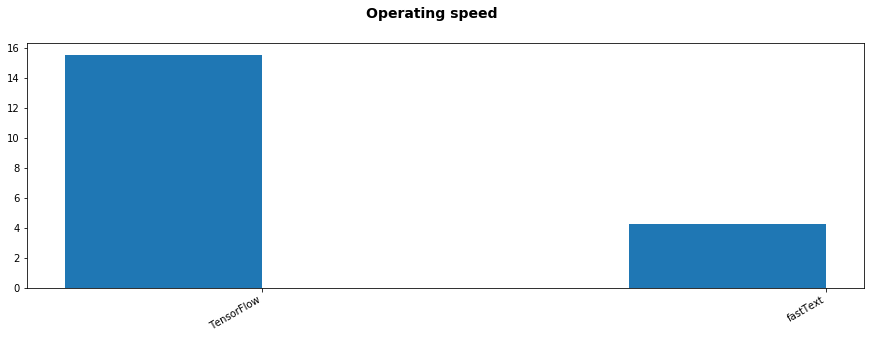

In [12]:
X = ['TensorFlow', 'fastText']
Y = [scores_timings[0][1],scores_timings[1][1]]
fig = plt.figure(figsize=(15,5))
fig.suptitle('Operating speed', fontsize=14, fontweight='bold')

width = .35
ind = np.arange(len(Y))
plt.bar(ind, Y, width=width)
plt.xticks(ind + width / 2, X)
    
fig.autofmt_xdate()

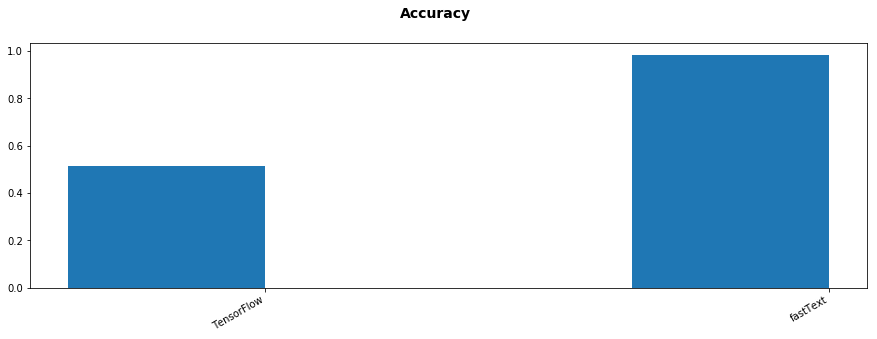

In [13]:
X = ['TensorFlow', 'fastText']
Y = [scores_timings[0][0], scores_timings[1][0]]
fig = plt.figure(figsize=(15,5))
fig.suptitle('Accuracy', fontsize=14, fontweight='bold')

width = .35
ind = np.arange(len(Y))
plt.bar(ind, Y, width=width)
plt.xticks(ind + width / 2, X)
    
fig.autofmt_xdate()

**What we see:**

* fastText works much faster than TensorFlow and has better accuracy.

* fastText can predict label by text